In [ ]:
!wget https://www.kaggle.com/api/v1/datasets/download/atharvadumbre/indian-sign-language-islrtc-referred

In [ ]:
!unzip indian-sign-language-islrtc-referred

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2  # 80% train, 20% val

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VALIDATION_SPLIT,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    "original_images",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    "original_images",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

NUM_CLASSES = train_generator.num_classes
print("Detected classes:", NUM_CLASSES)

Found 28800 images belonging to 36 classes.
Found 7200 images belonging to 36 classes.
Detected classes: 36


In [5]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)

outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [8]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "resnet50_best.keras",
        monitor="val_loss",
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]

In [9]:
history_stage1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 457s 491ms/step - accuracy: 0.3397 - loss: 2.3108 - val_accuracy: 0.7124 - val_loss: 0.8317 - learning_rate: 0.0010
Epoch 2/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 439s 488ms/step - accuracy: 0.7800 - loss: 0.6325 - val_accuracy: 0.7535 - val_loss: 0.6991 - learning_rate: 0.0010
Epoch 3/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 440s 488ms/step - accuracy: 0.8370 - loss: 0.4695 - val_accuracy: 0.7639 - val_loss: 0.6893 - learning_rate: 0.0010
Epoch 4/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 429s 476ms/step - accuracy: 0.8719 - loss: 0.3696 - val_accuracy: 0.7686 - val_loss: 0.6961 - learning_rate: 0.0010
Epoch 5/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 428s 475ms/step - accuracy: 0.8758 - loss: 0.3622 - val_accuracy: 0.8043 - val_loss: 0.5957 - learning_rate: 0.0010
Epoch 6/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 428s 475ms/step - accuracy: 0.8929 - loss: 0.3211 - val_accuracy: 0.8390 - val_loss: 0.5084 - learning_rate: 0.0010
Epoch 7/10
900/900 ━━━━━━━━━━━━━━━━━━━━ 428s 476ms/step - accura

In [10]:
import numpy as np

validation_generator.reset()
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes
class_names = list(validation_generator.class_indices.keys())

225/225 ━━━━━━━━━━━━━━━━━━━━ 94s 379ms/step


In [11]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names
))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       200
           1       0.94      0.88      0.90       200
           2       0.51      0.51      0.51       200
           3       0.67      0.79      0.73       200
           4       0.57      0.45      0.50       200
           5       0.80      0.75      0.78       200
           6       0.52      0.62      0.57       200
           7       0.61      0.75      0.67       200
           8       0.94      0.45      0.60       200
           9       0.76      0.64      0.69       200
           A       0.95      0.93      0.94       200
           B       0.99      1.00      1.00       200
           C       0.98      0.92      0.95       200
           D       0.97      0.94      0.96       200
           E       0.93      0.78      0.85       200
           F       0.96      0.84      0.90       200
           G       0.98      0.99      0.99       200
           H       0.99    

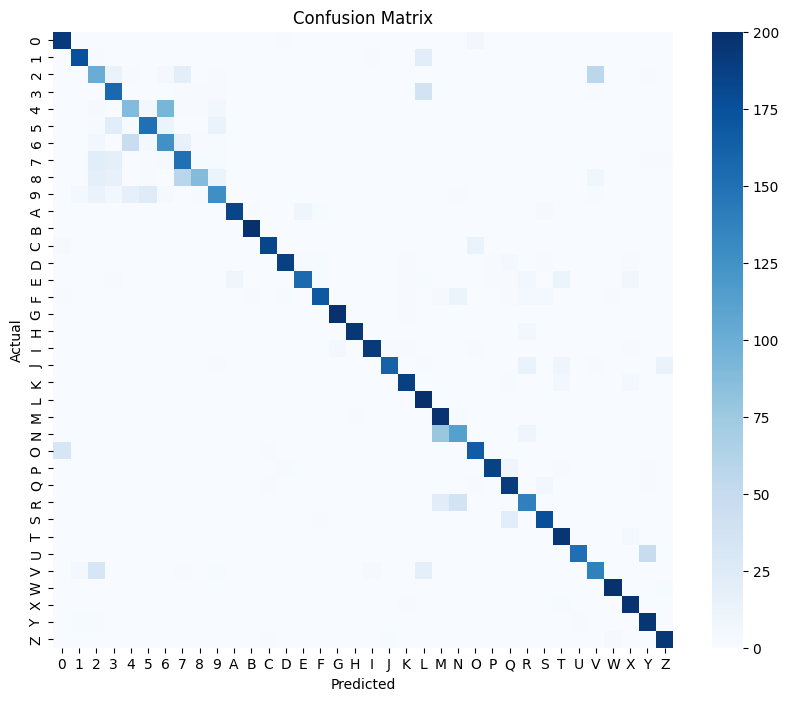

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()